In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_components
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from statsmodels.graphics import tsaplots
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

# Suppress specific statsmodels warnings about frequency
warnings.filterwarnings('ignore', 'No frequency information was provided')
warnings.filterwarnings('ignore', 'No supported index is available')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [130]:
df = pd.read_csv('data/co_avg.csv', parse_dates=['Date'])
df.head()

,Date,CO,StationCount
0,2010-01-01,1.249956,5
1,2010-01-16,1.211964,5
2,2010-02-01,1.240417,4
3,2010-02-16,1.334615,6
4,2010-03-01,1.078095,6


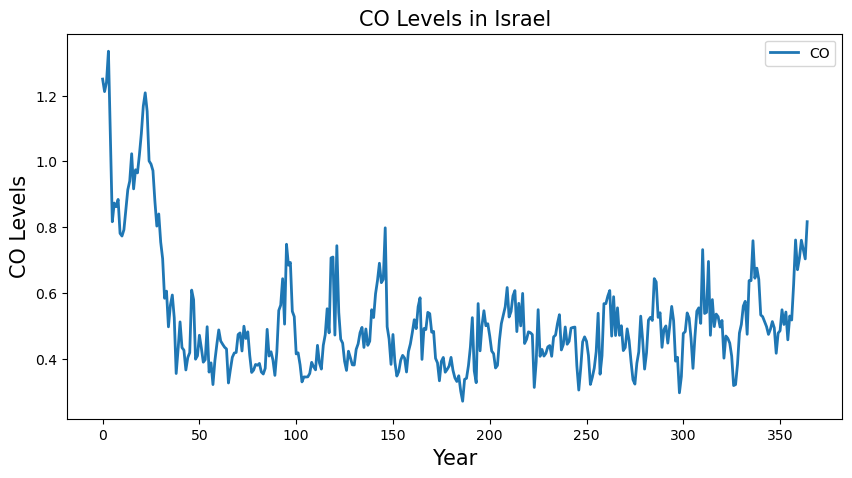

In [131]:
dfCO = df[["CO"]]
dfCO.plot(figsize=(10,5), linewidth=2, fontsize=10)
plt.title("CO Levels in Israel",fontsize=15)
plt.xlabel('Year', fontsize=15)

plt.ylabel('CO Levels', fontsize=15);

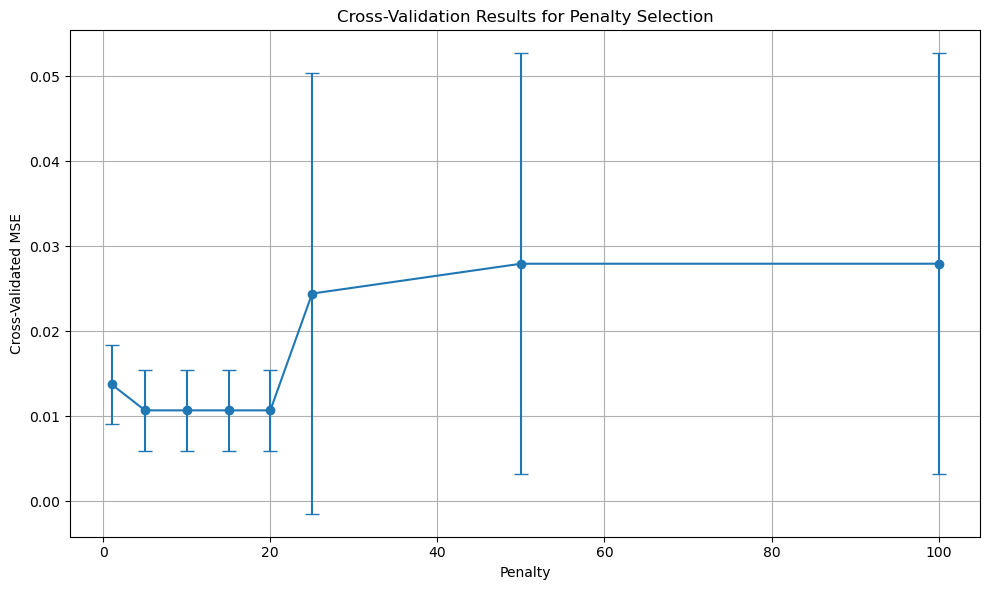

Best penalties based on MSE (within tolerance): [5, 10, 15, 20]
Multiple penalties have similar MSE. Using BIC as tiebreaker...


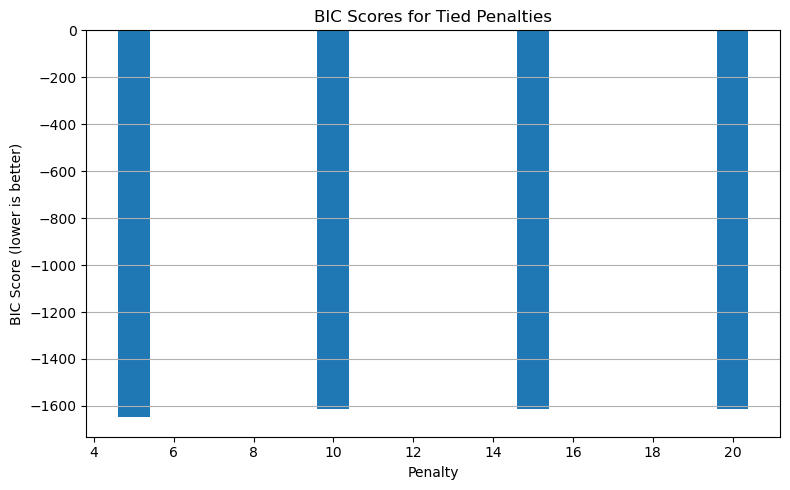

Optimal penalty based on BIC tiebreaker: 5
Change points detected with optimal penalty: [30, 195, 355, 365]


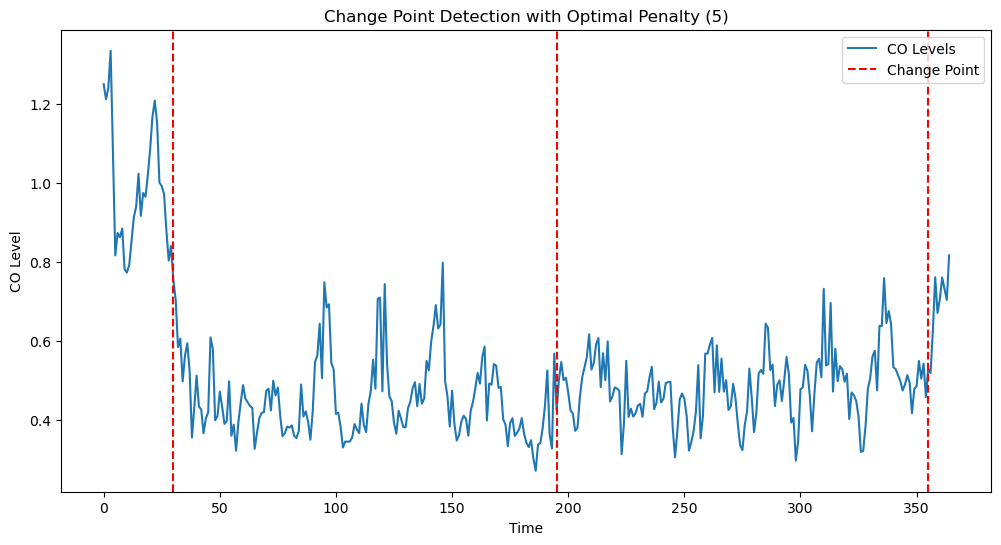

,Penalty,MSE,BIC,Num Change Points,Change Points,Change Point Dates
0,1,0.0138,-1789.1570,34,"[5, 15, 20, 25, 30, 40, 75, 90, 100, 115, 125, 130, 140, 145, 150, 160, 170, 180, 190, 200, 205, 220, 245, 260, 265, 285, 295, 300, 325, 330, 335, 340, 355, 360]","[5 (2010-03-16), 15 (2010-08-16), 20 (2010-11-01), 25 (2011-01-16), 30 (2011-04-01), 40 (2011-09-01), 75 (2013-02-16), 90 (2013-10-01), 100 (2014-03-01), 115 (2014-10-16), 125 (2015-03-16), 130 (2015-06-01), 140 (2015-11-01), 145 (2016-01-16), 150 (2016-04-01), 160 (2016-09-01), 170 (2017-02-01), 180 (2017-07-01), 190 (2017-12-01), 200 (2018-05-01), 205 (2018-07-16), 220 (2019-03-01), 245 (2020-03-16), 260 (2020-11-01), 265 (2021-01-16), 285 (2021-11-16), 295 (2022-04-16), 300 (2022-07-01), 325 (2023-07-16), 330 (2023-10-01), 335 (2023-12-16), 340 (2024-03-01), 355 (2024-10-16), 360 (2025-01-01)]"
1,5,0.0107,-1648.9137,3,"[30, 195, 355]","[30 (2011-04-01), 195 (2018-02-16), 355 (2024-10-16)]"
2,10,0.0107,-1613.2254,1,[30],[30 (2011-04-01)]
3,15,0.0107,-1613.2254,1,[30],[30 (2011-04-01)]
4,20,0.0107,-1613.2254,1,[30],[30 (2011-04-01)]
5,25,0.0244,-1254.0651,0,[],[]
6,50,0.0280,-1254.0651,0,[],[]
7,100,0.0280,-1254.0651,0,[],[]


,Penalty,MSE,BIC,Num Change Points
0,1,0.0138,-1789.1570,34
1,5,0.0107,-1648.9137,3
2,10,0.0107,-1613.2254,1
3,15,0.0107,-1613.2254,1
4,20,0.0107,-1613.2254,1
5,25,0.0244,-1254.0651,0
6,50,0.0280,-1254.0651,0
7,100,0.0280,-1254.0651,0


In [137]:
import ruptures as rpt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Load data
signal = df['CO'].values

# Define cross-validation function for MSE
def cv_penalty_selection(signal, penalty_range, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_results = {penalty: [] for penalty in penalty_range}
    
    for train_index, test_index in tscv.split(signal):
        train_signal = signal[train_index]
        test_signal = signal[test_index]
        
        for penalty in penalty_range:
            algo = rpt.Pelt(model="rbf").fit(train_signal)
            change_pts = algo.predict(pen=penalty)
            
            reconstructed = np.zeros_like(test_signal)
            if len(change_pts) == 0:
                reconstructed[:] = np.mean(train_signal)
            else:
                segments = []
                for i in range(len(change_pts)):
                    if i == 0:
                        segment = train_signal[0:change_pts[i]]
                    else:
                        segment = train_signal[change_pts[i-1]:change_pts[i]]
                    segments.append(np.mean(segment))
                reconstructed[:] = segments[-1]
            
            mse = mean_squared_error(test_signal, reconstructed)
            cv_results[penalty].append(mse)
    
    avg_mse = {penalty: np.mean(scores) for penalty, scores in cv_results.items()}
    std_mse = {penalty: np.std(scores) for penalty, scores in cv_results.items()}
    
    return avg_mse, std_mse

# Define function to calculate BIC
def calculate_bic(signal, penalty):
    algo = rpt.Pelt(model="rbf").fit(signal)
    change_pts = algo.predict(pen=penalty)
    
    # Calculate segments and their means
    segments = []
    for i in range(len(change_pts)):
        if i == 0:
            segment = signal[0:change_pts[i]]
        else:
            segment = signal[change_pts[i-1]:change_pts[i]]
        segments.append(segment)
    
    # Calculate reconstruction error
    reconstructed = np.zeros_like(signal)
    idx = 0
    for segment in segments:
        segment_mean = np.mean(segment)
        segment_len = len(segment)
        reconstructed[idx:idx+segment_len] = segment_mean
        idx += segment_len
    
    # Calculate residuals
    residuals = signal - reconstructed
    rss = np.sum(residuals**2)
    
    # Calculate BIC: BIC = n*ln(RSS/n) + k*ln(n)
    n = len(signal)
    k = len(change_pts) + 1  # number of parameters (segments)
    bic = n * np.log(rss/n) + k * np.log(n)
    
    return bic, change_pts

# Define penalty range
penalty_range = [1, 5, 10, 15, 20, 25, 50, 100]

# Step 1: Find best penalties based on MSE
avg_mse, std_mse = cv_penalty_selection(signal, penalty_range, n_splits=5)

# Plot MSE results
plt.figure(figsize=(10, 6))
plt.errorbar(
    list(avg_mse.keys()), 
    list(avg_mse.values()), 
    yerr=list(std_mse.values()),
    fmt='o-', capsize=5
)
plt.xlabel('Penalty')
plt.ylabel('Cross-Validated MSE')
plt.title('Cross-Validation Results for Penalty Selection')
plt.grid(True)
plt.tight_layout()
plt.show()

# Identify the best MSE scores with some tolerance
best_mse = min(avg_mse.values())
tolerance = 0.001  # 0.1% tolerance
tied_penalties = [p for p, mse in avg_mse.items() if mse <= best_mse + tolerance]

print(f"Best penalties based on MSE (within tolerance): {tied_penalties}")

# Step 2: If there are ties, use BIC as tiebreaker
if len(tied_penalties) > 1:
    print("Multiple penalties have similar MSE. Using BIC as tiebreaker...")
    
    bic_scores = {}
    change_points = {}
    
    for penalty in tied_penalties:
        bic, cp = calculate_bic(signal, penalty)
        bic_scores[penalty] = bic
        change_points[penalty] = cp
    
    # Plot BIC for tied penalties
    plt.figure(figsize=(8, 5))
    plt.bar(list(bic_scores.keys()), list(bic_scores.values()))
    plt.xlabel('Penalty')
    plt.ylabel('BIC Score (lower is better)')
    plt.title('BIC Scores for Tied Penalties')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
    optimal_penalty = min(bic_scores, key=bic_scores.get)
    optimal_change_pts = change_points[optimal_penalty]
    
    print(f"Optimal penalty based on BIC tiebreaker: {optimal_penalty}")
else:
    optimal_penalty = tied_penalties[0]
    algo_optimal = rpt.Pelt(model="rbf").fit(signal)
    optimal_change_pts = algo_optimal.predict(pen=optimal_penalty)
    
    print(f"Single optimal penalty based on MSE: {optimal_penalty}")

print(f"Change points detected with optimal penalty: {optimal_change_pts}")

# Final visualization with optimal penalty
plt.figure(figsize=(12, 6))
plt.plot(signal, label="CO Levels")
for cp in optimal_change_pts:
    if cp < len(signal):  # Ensure point is within data range
        plt.axvline(x=cp, color="red", linestyle="--", 
                   label="Change Point" if cp == optimal_change_pts[0] else "")
plt.title(f"Change Point Detection with Optimal Penalty ({optimal_penalty})")
plt.xlabel("Time")
plt.ylabel("CO Level")
plt.legend()
plt.show()
# ===== ADDED CODE: Table of Penalty Values =====
# Create a comprehensive table of all penalty values and their metrics
results_table = []

# Calculate metrics for all penalties
for penalty in penalty_range:
    # Run PELT algorithm with this penalty
    algo = rpt.Pelt(model="rbf").fit(signal)
    change_pts = algo.predict(pen=penalty)
    
    # Filter out the problematic change point at index 365
    filtered_change_pts = [cp for cp in change_pts if cp != 365]
    
    # Calculate BIC with filtered change points
    bic, _ = calculate_bic(signal, penalty)
    
    # Get CV MSE value
    mse = avg_mse.get(penalty, np.nan)
    
    # Convert change points to dates (assuming bimonthly data from Jan 2010)
    cp_dates = []
    for cp in filtered_change_pts:
        if cp < len(signal):
            # Calculate approximate date (each point is half a month)
            months_from_start = cp // 2
            day = "01" if cp % 2 == 0 else "16"
            year = 2010 + (months_from_start // 12)
            month = (months_from_start % 12) + 1
            date_str = f"{year}-{month:02d}-{day}"
            cp_dates.append(f"{cp} ({date_str})")
    
    # Add to results
    results_table.append({
        'Penalty': penalty,
        'MSE': mse,
        'BIC': bic,
        'Num Change Points': len(filtered_change_pts),
        'Change Points': filtered_change_pts,
        'Change Point Dates': cp_dates
    })

# Convert to DataFrame for better display
results_df = pd.DataFrame(results_table)

# Format the table
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 4)

# Display the table
display(results_df[['Penalty', 'MSE', 'BIC', 'Num Change Points', 'Change Points', 'Change Point Dates']])

# Create a focused view of the key metrics
summary_df = results_df[['Penalty', 'MSE', 'BIC', 'Num Change Points']]
display(summary_df)